In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [26]:
batch_size = 128
epochs = 10
lr = 1e-3
mc_samples = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

In [33]:
class CNN(nn.Module):
    def __init__(self, dropout_p=0.3, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=dropout_p)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.react_threshold = None

    def forward(self, x, apply_react=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        features = F.relu(self.fc1(x))

        if apply_react and self.react_threshold is not None:
            features = torch.clamp(features, max=self.react_threshold)

        features = self.dropout(features)
        logits = self.fc2(features)

        return logits, features

In [28]:
transform_cifar = transforms.Compose([
    transforms.ToTensor()
])

transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1))
])

train_id = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_id = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
test_ood = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_id_loader = DataLoader(train_id, batch_size=batch_size, shuffle=True)
test_id_loader = DataLoader(test_id, batch_size=batch_size, shuffle=False)
test_ood_loader = DataLoader(test_ood, batch_size=batch_size, shuffle=False)

In [34]:
def train(model, train_loader, epochs, lr):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        correct_samples = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            logits, _ = model(x)
            loss = loss_function(logits, y)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)

            correct_samples += (preds == y).sum().item()

        print(f'Epoch {epoch}; Train loss {total_loss / len(train_loader)}; Accuracy {correct_samples / len(train_loader) * 100}')

In [35]:
def compute_ood_metrics(id_scores, ood_scores):
    y_true = np.concatenate([
        np.zeros_like(id_scores),
        np.ones_like(ood_scores)
    ])
    scores = np.concatenate([id_scores, ood_scores])

    auroc = roc_auc_score(y_true, scores)
    aupr = average_precision_score(y_true, scores)

    fpr, tpr, _ = roc_curve(y_true, scores)
    target_tpr = 0.95
    idxs = np.where(tpr >= target_tpr)[0]
    if len(idxs) > 0:
        fpr95 = fpr[idxs[0]]
    else:
        fpr95 = 1.0

    print(f'AUROC {auroc}')
    print(f'AUPR {aupr}')
    print(f'FPR@95%TPR {fpr95}')

    return auroc, aupr, fpr95

In [39]:
def get_softmax_ood_scores(model, id_loader, ood_loader):
    model.to(device)
    model.eval()

    id_scores = []
    ood_scores = []

    with torch.no_grad():
        for x, _ in id_loader:
            x = x.to(device)
            logits, _ = model(x)
            probs = F.softmax(logits, dim=1)
            max_probs, _ = probs.max(dim=1)
            scores = 1.0 - max_probs

            id_scores.append(scores.cpu().numpy())

    with torch.no_grad():
        for x, _ in ood_loader:
            x = x.to(device)
            logits, _ = model(x)
            probs = F.softmax(logits, dim=1)
            max_probs, _ = probs.max(dim=1)
            scores = 1.0 - max_probs

            ood_scores.append(scores.cpu().numpy())

    id_scores = np.concatenate(id_scores)
    ood_scores = np.concatenate(ood_scores)

    return id_scores, ood_scores


def get_mcd_ood_entropy(model, x, T=20):
    model.to(device)
    model.train()

    with torch.no_grad():
        probs_T = []
        for _ in range(T):
            logits, _ = model(x)
            probs = F.softmax(logits, dim=1)

            probs_T.append(probs.unsqueeze(0))

        probs_T = torch.cat(probs_T, dim=0)

    p_mean = probs_T.mean(dim=0)

    eps = 1e-8
    entropy = -torch.sum(p_mean * torch.log(p_mean + eps), dim=1)

    return entropy


def get_mcd_ood_scores(model, id_loader, ood_loader, T=20):
    model.to(device)

    id_scores = []
    ood_scores = []

    for x, _ in id_loader:
        x = x.to(device)
        entropy = get_mcd_ood_entropy(model, x, T=T)

        id_scores.append(entropy.cpu().numpy())

    for x, _ in ood_loader:
        x = x.to(device)
        entropy = get_mcd_ood_entropy(model, x, T=T)

        ood_scores.append(entropy.cpu().numpy())

    id_scores = np.concatenate(id_scores)
    ood_scores = np.concatenate(ood_scores)

    return id_scores, ood_scores

In [37]:
model = CNN(dropout_p=0.3, num_classes=10)
train(model, train_id_loader, epochs=epochs, lr=lr)

Epoch 1; Train loss 1.7378662187425071; Accuracy 4631.713554987212
Epoch 2; Train loss 1.3914910390248993; Accuracy 6304.60358056266
Epoch 3; Train loss 1.2519350756159828; Accuracy 7057.289002557544
Epoch 4; Train loss 1.1446668787685501; Accuracy 7561.3810741687985
Epoch 5; Train loss 1.07378920950853; Accuracy 7900.5115089514065
Epoch 6; Train loss 1.0127810168144342; Accuracy 8173.913043478261
Epoch 7; Train loss 0.962541143760047; Accuracy 8431.457800511509
Epoch 8; Train loss 0.9254818540399946; Accuracy 8605.626598465473
Epoch 9; Train loss 0.8904001279865079; Accuracy 8778.005115089514
Epoch 10; Train loss 0.8640787584702377; Accuracy 8892.327365728901


In [40]:
softmax_id_scores, softmax_ood_scores = get_softmax_ood_scores(model, test_id_loader, test_ood_loader)

In [52]:
print('softmax scores')
softmax_auroc, softmax_aupr, softmax_fpr95 = compute_ood_metrics(softmax_id_scores, softmax_ood_scores)

softmax scores
AUROC 0.6708571299999999
AUPR 0.630617546326034
FPR@95%TPR 0.787


In [42]:
mcd_id_scores, mcd_ood_scores = get_mcd_ood_scores(model, test_id_loader, test_ood_loader)

In [50]:
print('mcd scores')
mcd_auroc, mcd_aupr, mcd_fpr95 = compute_ood_metrics(mcd_id_scores, mcd_ood_scores)

mcd scores
AUROC 0.7405450549999999
AUPR 0.6787008798842136
FPR@95%TPR 0.686


In [44]:
def estimate_react_threshold(model, train_loader, quantile=0.95):
    model.eval()
    model.to(device)

    feats = []

    with torch.no_grad():
        for x, _ in train_loader:
            x = x.to(device)
            _, features = model(x, apply_react=False)
            feats.append(features.cpu())

    feats = torch.cat(feats, dim=0)
    threshold = torch.quantile(feats, quantile)

    return threshold.item()

In [45]:
model.react_threshold = estimate_react_threshold(
    model,
    train_id_loader,
    quantile=0.95
)
model.react_threshold

1.7036713361740112

In [46]:
def get_react_ood_scores(model, id_loader, ood_loader):
    model.eval()
    model.to(device)

    id_scores, ood_scores = [], []

    with torch.no_grad():
        for x, _ in id_loader:
            x = x.to(device)
            logits, _ = model(x, apply_react=True)
            probs = F.softmax(logits, dim=1)
            scores = 1.0 - probs.max(dim=1)[0]
            id_scores.append(scores.cpu().numpy())

        for x, _ in ood_loader:
            x = x.to(device)
            logits, _ = model(x, apply_react=True)
            probs = F.softmax(logits, dim=1)
            scores = 1.0 - probs.max(dim=1)[0]
            ood_scores.append(scores.cpu().numpy())

    return np.concatenate(id_scores), np.concatenate(ood_scores)

In [47]:
react_id_scores, react_ood_scores = get_react_ood_scores(model, test_id_loader, test_ood_loader)

In [51]:
print('react scores')
react_auroc, react_aupr, react_fpr95 = compute_ood_metrics(react_id_scores, react_ood_scores)

react scores
AUROC 0.76122652
AUPR 0.7264645812759986
FPR@95%TPR 0.6285


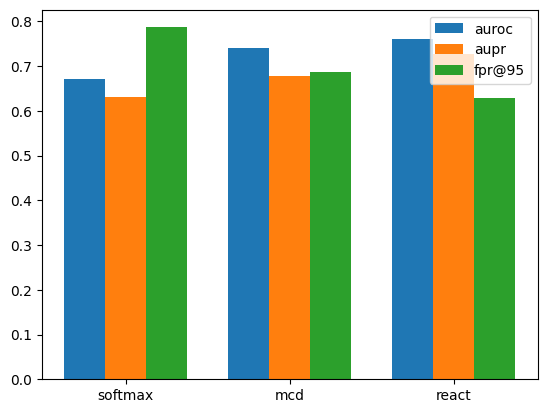

In [55]:
methods = ['softmax', 'mcd', 'react']

aurocs = [softmax_auroc, mcd_auroc, react_auroc]
auprs = [softmax_aupr, mcd_aupr, react_aupr]
fpr95s = [softmax_fpr95, mcd_fpr95, react_fpr95]

x = np.arange(len(methods))
width = 0.25

plt.figure()
plt.bar(x - width, aurocs, width, label='auroc')
plt.bar(x, auprs, width, label='aupr')
plt.bar(x + width, fpr95s, width, label='fpr@95')

plt.xticks(x, methods)
plt.legend()
plt.show()

In [ ]:
# react > mcd > softmax 
# auroc и aucpr растут, fpr@95 падает; fpr@95 особенно хорошо упал